# FNO applied to guitar string

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [3]:
# finite-difference wave solver
def solve_wave(u0, c=1.0, nx=128, nt=100):
    dx = 1/(nx-1)
    dt = 0.5*dx  # stable CFL

    x = np.linspace(0,1,nx)
    t = np.linspace(0,1,nt)

    u = np.zeros((nt, nx))
    u[0] = u0

    # zero initial velocity
    u[1,1:-1] = u[0,1:-1] + (c*dt)**2/(dx**2) * \
        (u[0,2:] - 2*u[0,1:-1] + u[0,:-2])

    # time stepping
    for n in range(1, nt-1):
        u[n+1,1:-1] = (2*u[n,1:-1] - u[n-1,1:-1] +
                       (c*dt)**2/(dx**2) *
                       (u[n,2:] - 2*u[n,1:-1] + u[n,:-2]))

    return x, t, u


In [4]:
def random_initial_condition(nx, max_modes=6):
    x = torch.linspace(0, 1, nx, dtype=torch.float32)
    A = torch.randn(max_modes) * torch.exp(-0.3 * torch.arange(max_modes))
    u0 = sum(A[n] * torch.sin((n+1) * np.pi * x) for n in range(max_modes))
    return u0


def build_dataset(dataset_size=2000, nx=128, nt=100, max_modes=6):
    dataset = []
    for _ in range(dataset_size):
        u0 = random_initial_condition(nx, max_modes)
        _, _, sol = solve_wave(u0, nx=nx, nt=nt)  # sol is numpy array (nt, nx)
        dataset.append((u0, sol))
    return dataset


dataset = build_dataset(dataset_size=2000)

dataset_u0 = torch.stack([u0.to(torch.float32) for u0, _ in dataset]).to(device)        # (2000, nx)
dataset_sol = torch.stack([torch.tensor(sol, dtype=torch.float32) for _, sol in dataset]).to(device)     # (2000, nt, nx)


/tmp/ipykernel_240128/1755040737.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  u[0] = u0


In [5]:
# Create coordinate grid only once
nt, nx = 100, 128

t_grid = torch.linspace(0, 1, nt, device=device)
x_grid = torch.linspace(0, 1, nx, device=device)
T, X = torch.meshgrid(t_grid, x_grid, indexing="ij")

# (1, nt, nx)
T = T.unsqueeze(0)
X = X.unsqueeze(0)


In [6]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes_t, modes_x):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes_t = modes_t
        self.modes_x = modes_x

        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.randn(in_channels, out_channels, modes_t, modes_x, dtype=torch.cfloat)
        )

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize, channels, nt, nx = x.shape

        # FFT: (batch, channels, nt, nx//2+1)
        x_ft = torch.fft.rfft2(x, s=(nt, nx))

        out_ft = torch.zeros(
            batchsize, self.out_channels, nt, nx//2 + 1,
            dtype=torch.cfloat, device=x.device
        )

        # Apply learned weights to lowest modes
        out_ft[:, :, :self.modes_t, :self.modes_x] = \
            self.compl_mul2d(x_ft[:, :, :self.modes_t, :self.modes_x], self.weights)

        # back to physical space
        x = torch.fft.irfft2(out_ft, s=(nt, nx))
        return x


In [7]:
class FNO2D(nn.Module):
    def __init__(self, modes_t=16, modes_x=16, width=64, nt=100, nx=128):
        super().__init__()
        self.modes_t = modes_t
        self.modes_x = modes_x
        self.width = width
        self.nt = nt
        self.nx = nx

        # Lift input channels (u0, t, x) → width
        self.fc0 = nn.Linear(3, width)

        # Fourier layers
        self.conv0 = SpectralConv2d(width, width, modes_t, modes_x)
        self.conv1 = SpectralConv2d(width, width, modes_t, modes_x)
        self.conv2 = SpectralConv2d(width, width, modes_t, modes_x)
        self.conv3 = SpectralConv2d(width, width, modes_t, modes_x)

        self.w0 = nn.Conv2d(width, width, 1)
        self.w1 = nn.Conv2d(width, width, 1)
        self.w2 = nn.Conv2d(width, width, 1)
        self.w3 = nn.Conv2d(width, width, 1)

        # Projection back to scalar field
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, u0):
        batch = u0.shape[0]

        # (batch, nt, nx)
        u0_grid = u0.unsqueeze(1).repeat(1, self.nt, 1)

        # Broadcast coordinates
        T_batch = T.repeat(batch, 1, 1)
        X_batch = X.repeat(batch, 1, 1)

        # Stack channels
        inp = torch.stack([u0_grid, T_batch, X_batch], dim=-1)  # (batch, nt, nx, 3)

        # Lift to width channels
        u = self.fc0(inp)
        u = u.permute(0, 3, 1, 2)  # (batch, width, nt, nx)

        # 4 FNO blocks
        for conv, w in [
            (self.conv0, self.w0),
            (self.conv1, self.w1),
            (self.conv2, self.w2),
            (self.conv3, self.w3),
        ]:
            u = conv(u) + w(u)
            u = torch.relu(u)

        # project down to scalar
        u = u.permute(0, 2, 3, 1)  # (batch, nt, nx, width)

        u = torch.relu(self.fc1(u))
        u = self.fc2(u).squeeze(-1)  # (batch, nt, nx)

        return u


In [8]:
model = FNO2D(
    modes_t=16,
    modes_x=16,
    width=64,
    nt=100,
    nx=128
).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


In [9]:
batch_size = 10
epochs = 3000

for epoch in range(epochs):
    idx = torch.randint(0, dataset_u0.shape[0], (batch_size,), device=device)

    u0_batch = dataset_u0[idx]       # (batch, nx)
    sol_batch = dataset_sol[idx]     # (batch, nt, nx)

    pred = model(u0_batch)
    loss = loss_fn(pred, sol_batch)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.4e}")


Epoch 0, Loss = 5.8564e-01
Epoch 100, Loss = 1.0176e-02
Epoch 200, Loss = 2.7535e-03
Epoch 300, Loss = 1.4553e-03
Epoch 400, Loss = 7.3617e-04
Epoch 500, Loss = 7.2537e-04
Epoch 600, Loss = 6.8123e-04
Epoch 700, Loss = 1.1045e-03
Epoch 800, Loss = 1.5384e-03
Epoch 900, Loss = 6.4057e-04
Epoch 1000, Loss = 3.4859e-04
Epoch 1100, Loss = 2.9790e-03
Epoch 1200, Loss = 2.5169e-04
Epoch 1300, Loss = 2.6491e-04
Epoch 1400, Loss = 1.5377e-03
Epoch 1500, Loss = 5.4324e-04
Epoch 1600, Loss = 4.2526e-04
Epoch 1700, Loss = 3.9178e-04
Epoch 1800, Loss = 2.7303e-04
Epoch 1900, Loss = 4.3811e-04
Epoch 2000, Loss = 4.1566e-04
Epoch 2100, Loss = 7.8924e-04
Epoch 2200, Loss = 1.3695e-03
Epoch 2300, Loss = 6.8623e-04
Epoch 2400, Loss = 6.6105e-04
Epoch 2500, Loss = 4.0444e-04
Epoch 2600, Loss = 4.2609e-04
Epoch 2700, Loss = 2.0112e-03
Epoch 2800, Loss = 2.8999e-04
Epoch 2900, Loss = 1.5310e-03


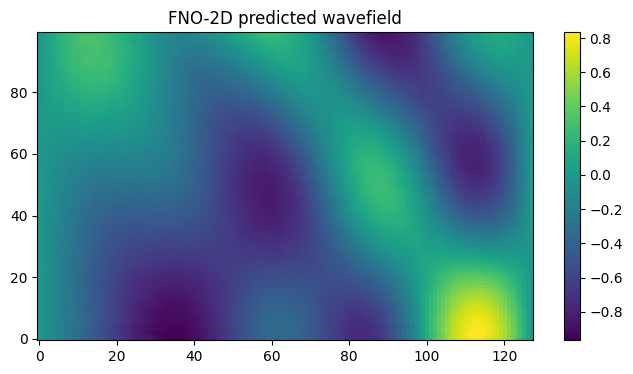

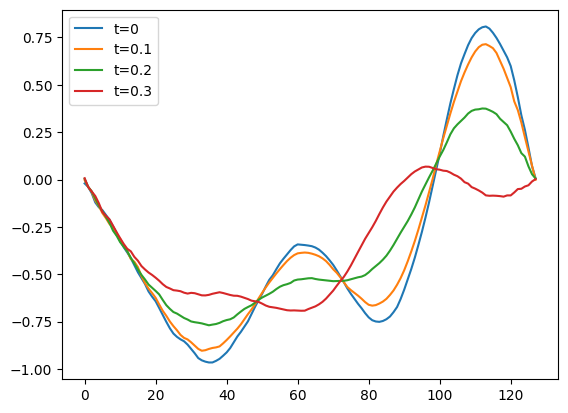

In [13]:
i = 0  # pick example
u0_single = dataset_u0[i]
sol_single = dataset_sol[i]

pred = model(u0_single.unsqueeze(0)).detach().cpu()[0]

plt.figure(figsize=(8,4))
plt.imshow(pred, aspect='auto', origin='lower')
plt.colorbar()
plt.title("FNO-2D predicted wavefield")
plt.show()

plt.figure()
plt.plot(pred[0], label="t=0")
plt.plot(pred[10], label="t=0.1")
plt.plot(pred[20], label="t=0.2")
plt.plot(pred[30], label="t=0.3")
plt.legend()
plt.show()
